In [113]:
import copy
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

#-- Pytorch specific libraries import -----#
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [114]:
def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()    
device = "cuda" if torch.cuda.is_available() else "cpu"
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [115]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Mar 27 17:32:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              32W / 250W |    326MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [116]:
merged_data_with_g_a = pd.read_csv('/kaggle/input/bbdc-2024/merged_preprocessed_data_with_info_numericSamples.csv') #/kaggle/input/bbdc-2024
merged_data_with_g_a = merged_data_with_g_a.drop(['notification', 'engagement', 'timestamp' , 'sessionId', 'timestamp_seconds'], axis=1)

In [117]:
x_data = merged_data_with_g_a.drop(['affect', 'context'], axis=1)
y_data_kontext = merged_data_with_g_a.drop(['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus', 'gender', 'age', 'affect'], axis=1)
y_data_affect = merged_data_with_g_a.drop(['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus', 'gender', 'age', 'context'], axis=1)

## Kontext

In [118]:
X_train, X_test, y_kontext_train, y_kontext_test = train_test_split(x_data, y_data_kontext, random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

le = LabelEncoder()
y_kontext_train = le.fit_transform(y_kontext_train)
y_kontext_test = le.transform(y_kontext_test)

# Umwandlung in Tensoren
x_train_tensor =  torch.from_numpy(X_train).float()
y_train_tensor =  torch.from_numpy(y_kontext_train.ravel()).long() #.float()
#y_train_tensor = y_train_tensor.unsqueeze(1)
x_test_tensor =  torch.from_numpy(X_test).float()
y_test_tensor =  torch.from_numpy(y_kontext_test.ravel()).long() #.float()
#y_test_tensor = y_test_tensor.unsqueeze(1)

print("\nTrain set Tensors \n")
print(x_train_tensor)
print(y_train_tensor)
print("\nTest set Tensors \n")
print(x_test_tensor)
print(y_test_tensor)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



Train set Tensors 

tensor([[-1.9852,  1.1960, -0.1829,  ...,  1.0000,  1.0000,  0.0000],
        [ 0.0588, -0.9942, -0.0280,  ...,  0.0000,  1.0000,  1.0000],
        [ 0.3258,  1.8428,  1.4289,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.5653, -0.6136, -2.1034,  ...,  1.0000,  1.0000,  0.0000],
        [-0.1959, -0.9565, -0.7541,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3624, -0.3566, -0.8010,  ...,  1.0000,  1.0000,  0.0000]])
tensor([1, 3, 1,  ..., 0, 2, 1])

Test set Tensors 

tensor([[ 0.1506, -0.9459,  1.0528,  ...,  0.0000,  0.0000,  1.0000],
        [-0.4855, -0.2055,  0.8106,  ...,  1.0000,  0.0000,  1.0000],
        [-1.4376,  0.3656,  0.3084,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.3556, -0.3360,  0.2348,  ...,  1.0000,  1.0000,  0.0000],
        [ 1.6735, -0.0825,  0.5272,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.8223,  0.0441,  1.3335,  ...,  0.0000,  1.0000,  0.0000]])
tensor([1, 0, 0,  ..., 1, 0, 2])


In [119]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
#train_dataloader = DataLoader(train_dataset, batch_size=16)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
#test_dataloader = DataLoader(test_dataset, batch_size=16)

In [120]:
n_input_dim = X_train.shape[1]
n_output = 4

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 32) 
        self.layer_2 = nn.Linear(32, 64)
        self.layer_out = nn.Linear(64, n_output) 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    

model = Model()
print(model)

Model(
  (layer_1): Linear(in_features=10, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [127]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        #print(labels)
        optimizer.zero_grad()

        outputs = model(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        probs = torch.softmax(outputs, dim=-1) #Wahrscheinlichkeit, dass eine bestimmte Ausgabe zu einer bestimmten Klasse gehört
        preds = torch.argmax(probs, 1) 
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [133]:
# ===== https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, tolerance = 5, min_delta = 0.005):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = None #float('inf') #np.Inf

    def early_stopp(self, validation_loss):
        if self.min_validation_loss == None:
            self.min_validation_loss = validation_loss
        elif (self.min_validation_loss - validation_loss) > self.min_delta: 
            self.min_validation_loss = validation_loss
            self.counter=0
        elif (self.min_validation_loss - validation_loss) < self.min_delta: 
            self.counter +=1
            if self.counter >=self.tolerance:
                return True
        return False

def eval_epoch(model, val_loader, criterion, optimizer, epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    early_stopper = EarlyStopper()
    best_loss = np.inf

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=-1) #Wahrscheinlichkeit, dass eine bestimmte Ausgabe zu einer bestimmten Klasse gehört
            preds = torch.argmax(probs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    
     # Speichern das Modell
    if val_loss < best_loss:
        best_loss = val_loss
        experiment_state_dict={
            'model':model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
        }
        torch.save(experiment_state_dict, "model_kontext.pth")
    
    '''if early_stopper.early_stopp(val_loss):
        print("#########################")
        print("Early stopping triggered!")
        print("#########################")
        break'''
    
    return val_loss, val_acc

In [129]:
def train(train_dataset, test_dataset, model, epochs, batch_size, optimizer, criterion):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #test_dataloader = DataLoader(test_dataset, batch_size=16)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer = optimizer
        criterion = criterion

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, test_loader, criterion, optimizer, epoch)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [125]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()#.to(device) #.cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [130]:
model = Model().to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
history = train(train_dataset, test_dataset, model=model, epochs=5, batch_size=16, optimizer = optimizer, criterion = criterion)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.3002596846574683


epoch:  20%|██        | 1/5 [02:49<11:19, 169.86s/it]


Epoch 001 train_loss: 1.3003     val_loss 1.3088 train_acc 0.3812 val_acc 0.3879
loss 1.2881527704768008


epoch:  40%|████      | 2/5 [05:39<08:29, 170.00s/it]


Epoch 002 train_loss: 1.2882     val_loss 1.2840 train_acc 0.3905 val_acc 0.3952
loss 1.2851783797998562


epoch:  60%|██████    | 3/5 [08:29<05:39, 169.68s/it]


Epoch 003 train_loss: 1.2852     val_loss 1.2794 train_acc 0.3917 val_acc 0.3994
loss 1.28279283070418


epoch:  80%|████████  | 4/5 [11:18<02:49, 169.44s/it]


Epoch 004 train_loss: 1.2828     val_loss 1.2779 train_acc 0.3948 val_acc 0.4004
loss 1.282450087340696


epoch: 100%|██████████| 5/5 [14:08<00:00, 169.68s/it]


Epoch 005 train_loss: 1.2825     val_loss 1.2947 train_acc 0.3948 val_acc 0.4053


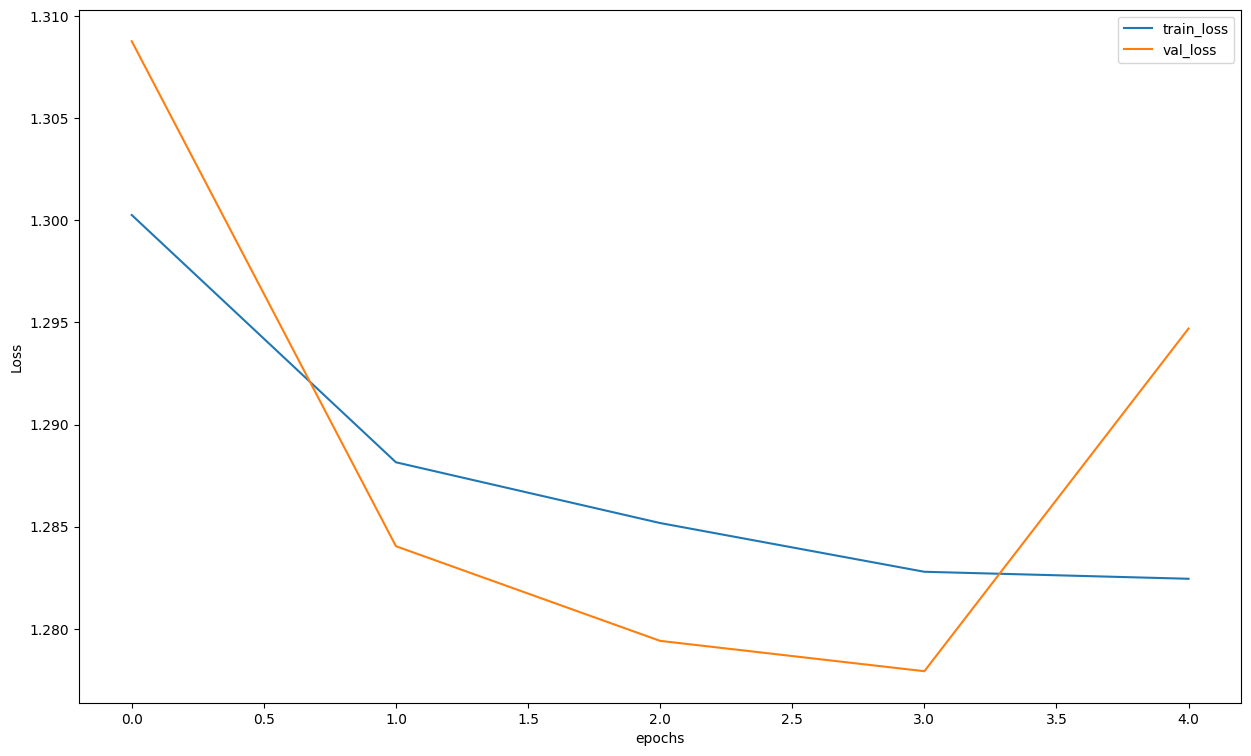

In [134]:
train_loss, train_acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

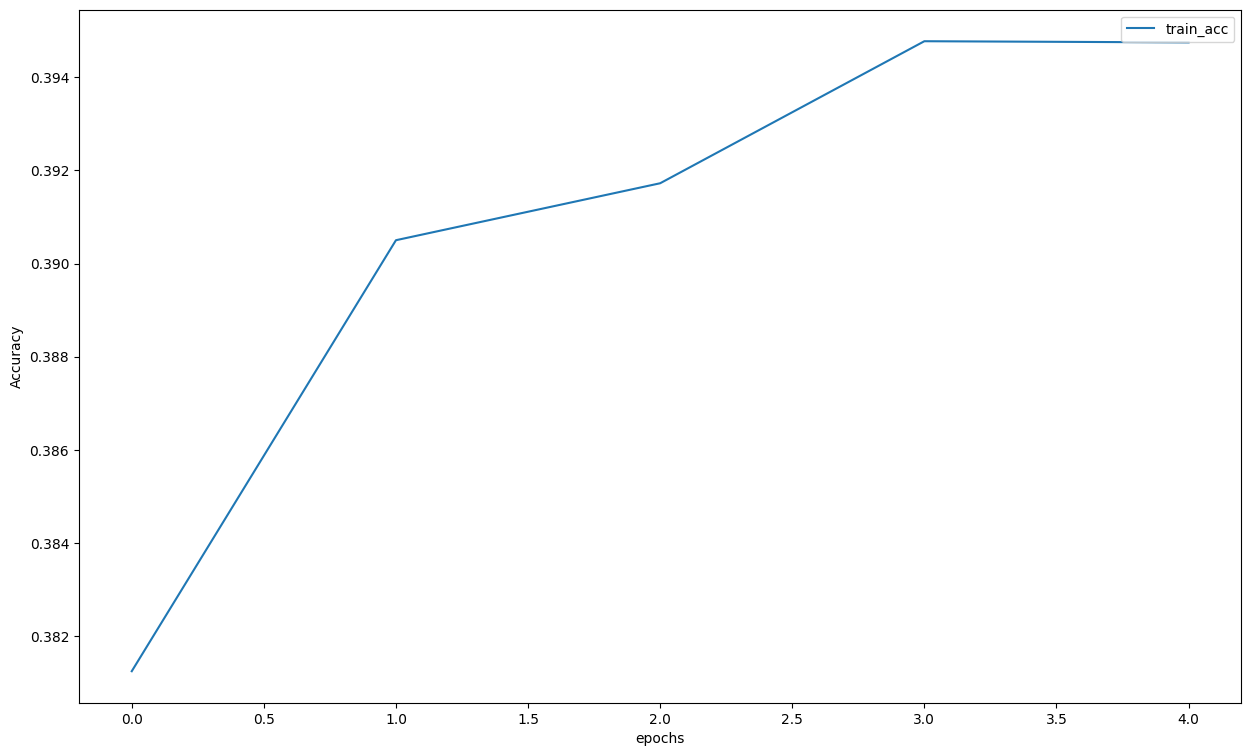

In [135]:
plt.figure(figsize=(15, 9))
plt.plot(train_acc, label="train_acc")
#plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()